In [3]:
import scipy.io
import numpy as np
import os
import scipy.signal as signal
import tqdm

from scipy.signal import butter, lfilter

import pandas as pd
from mne.decoding import CSP
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score

In [4]:
def butter_bandpass_filter(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs

    low = lowcut / nyquist
    high = highcut / nyquist

    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass_filter(lowcut, highcut, fs, order)
    return lfilter(b, a, data, axis=0)

def load_data(path, lowcut= 8, highcut = 30) -> tuple:

    data = scipy.io.loadmat(path)

    # mentioned in bci comp docs
    cnt = data['cnt'].astype(np.float32) * 0.1

    fs = data['nfo']['fs'][0,0]

    cnt = apply_filter(cnt, lowcut, highcut, fs)

    mrk_pos = data['mrk']['pos'][0][0].flatten()
    mrk_label = data['mrk']['y'][0][0].flatten()

    cue_min, cue_max = 0.5, 2.5
    cue_min_samples = int(cue_min * fs)
    cue_max_samples = int(cue_max * fs)
    window = cue_max_samples - cue_min_samples

    num_trials = len(mrk_pos)
    num_channels = cnt.shape[1]
    
    X= np.zeros((num_trials, num_channels, window))

    for i, pos in enumerate(mrk_pos):
        start, end = pos + cue_min_samples, pos + cue_max_samples

        if end > cnt.shape[0]:
            break

        X[i] = cnt[start:end, :].T

    
    y = mrk_label[:X.shape[0]]

    return (X, y, fs)


def get_labeled_inds(X, y):
    valid_indices = ~np.isnan(y)

    x_labeled = X[valid_indices]
    y_labeled = y[valid_indices]

    #trials, channels, window
    #print(x_train.shape)
    #rint(y_train.shape)

    return x_labeled, y_labeled

def extract_CSP(X, y):
    csp_per_class = 6

    csp = CSP(n_components=6)

    X_csp = csp.fit_transform(X, y)

    print("Transformed CSP data shape:", X_csp.shape)

    return X_csp

def classify_LDA(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=4,)
    


    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train, y_train)  # Train LDA
    y_pred = lda.predict(X_test)  # Predict

    lda_2 = LinearDiscriminantAnalysis()
    scores = cross_val_score(lda_2, X, y, cv=5 )

    # Calculate accuracy
    accuracy = np.mean(y_pred == y_test) * 100
    #print(f"LDA Classification Accuracy: {accuracy:.2f}%")
    return accuracy, scores




# Loading Data

In [5]:

file_path_parent = 'data/bca_3_4a'
abs_path = os.path.abspath(file_path_parent)
#print(abs_path)

paths = []
for root, _, files in os.walk(abs_path):

    for file in files:
        paths.append(os.path.join(root,file))


In [6]:
data_per_subject = []

for path in paths:
    
    # tuple of (X, y, fs)
    data = load_data(path)
    data_per_subject.append(data) 
    
print(len(data_per_subject))


C:\Users\jacob\AppData\Local\Temp\ipykernel_512\469286955.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cue_min_samples = int(cue_min * fs)
C:\Users\jacob\AppData\Local\Temp\ipykernel_512\469286955.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cue_max_samples = int(cue_max * fs)


5


In [7]:
test_data = data_per_subject[0]
X = test_data[0]
print(X.shape)

y = test_data[1]
print(y.shape)

(280, 118, 200)
(280,)


# Extracting Features

In [8]:
accuracy_scores = []
cross_val_scores = []
csp_features_per_subject = []
labels_per_subject = []

for data in data_per_subject:

    X = data[0]
    y = data[1]

    x_train, y_train = get_labeled_inds(X,y)
    labels_per_subject.append(y_train)

    X_csp = extract_CSP(x_train, y_train)
    csp_features_per_subject.append(X_csp)

    accuracy, scores = classify_LDA(X_csp, y_train)
    accuracy_scores.append(accuracy)
    cross_val_scores.append(scores)
    #print(accuracy)

Computing rank from data with rank=None
    Using tolerance 2.4e+02 (2.2e-16 eps * 118 dim * 9.1e+15  max singular value)
    Estimated rank (data): 118
    data: rank 118 computed from 118 data channels with 0 projectors
Reducing data rank from 118 -> 118
Estimating class=1.0 covariance using EMPIRICAL
Done.
Estimating class=2.0 covariance using EMPIRICAL
Done.
Transformed CSP data shape: (168, 6)
Computing rank from data with rank=None
    Using tolerance 3.6e+02 (2.2e-16 eps * 118 dim * 1.4e+16  max singular value)
    Estimated rank (data): 118
    data: rank 118 computed from 118 data channels with 0 projectors
Reducing data rank from 118 -> 118
Estimating class=1.0 covariance using EMPIRICAL
Done.
Estimating class=2.0 covariance using EMPIRICAL
Done.
Transformed CSP data shape: (224, 6)
Computing rank from data with rank=None
    Using tolerance 1.4e+02 (2.2e-16 eps * 118 dim * 5.4e+15  max singular value)
    Estimated rank (data): 118
    data: rank 118 computed from 118 data c

In [9]:
print(accuracy_scores)
print(np.mean(cross_val_scores, axis=1))

[88.23529411764706, 97.77777777777777, 76.47058823529412, 91.66666666666666, 100.0]
[0.89358289 0.96444444 0.81102941 0.94545455 1.        ]


In [10]:
x_1 = csp_features_per_subject[0]
x_2 = csp_features_per_subject[2]

y_1 = labels_per_subject[0]
y_2 = labels_per_subject[2]

lda = LinearDiscriminantAnalysis()

lda.fit(x_1, y_1)

y_pred = lda.predict(x_2)

print(accuracy_score(y_2, y_pred))

0.8095238095238095


# Testing the Rotation and Jitter of Features for RL

In [13]:
import numpy as np
from scipy.linalg import orth

def rotate_features(X, angle=10):
    """
    Applies a small rotation to CSP feature space.
    
    Parameters:
    - X: (n_samples, n_features) CSP features.
    - angle: Rotation angle in degrees.

    Returns:
    - X_rotated: Rotated feature set.
    """
    n_features = X.shape[1]
    
    # Generate a random orthogonal rotation matrix
    random_matrix = np.random.randn(n_features, n_features)
    rotation_matrix = orth(random_matrix)  # Orthonormal matrix

    # Apply small rotation
    angle_rad = np.deg2rad(angle)
    rotation_matrix = np.eye(n_features) + angle_rad * (rotation_matrix - np.eye(n_features))

    X_rotated = X @ rotation_matrix
    return X_rotated




In [14]:
def jitter_features(X, noise_level=0.08):
    """
    Adds small Gaussian noise to CSP features.
    
    Parameters:
    - X: (n_samples, n_features) CSP features.
    - noise_level: Standard deviation of noise.

    Returns:
    - X_jittered: Noisy feature set.
    """
    noise = np.random.normal(0, noise_level, X.shape)
    return X + noise

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_pca(X_original, X_transformed, title_original="Original Features", title_transformed="Transformed Features"):
    """
    Plots 2D PCA of CSP features before and after transformation.
    
    Parameters:
    - X_original: (n_samples, n_features) Original CSP features.
    - X_transformed: (n_samples, n_features) Transformed CSP features.
    """
    pca = PCA(n_components=2)
    X_original_pca = pca.fit_transform(X_original)
    X_transformed_pca = pca.transform(X_transformed)

    plt.figure(figsize=(12, 5))

    # Original features
    plt.subplot(1, 2, 1)
    plt.scatter(X_original_pca[:, 0], X_original_pca[:, 1], alpha=0.7)
    plt.title(title_original)
    plt.xlabel("PC1")
    plt.ylabel("PC2")

    # Transformed features
    plt.subplot(1, 2, 2)
    plt.scatter(X_transformed_pca[:, 0], X_transformed_pca[:, 1], alpha=0.7)
    plt.title(title_transformed)
    plt.xlabel("PC1")
    plt.ylabel("PC2")

    plt.show()

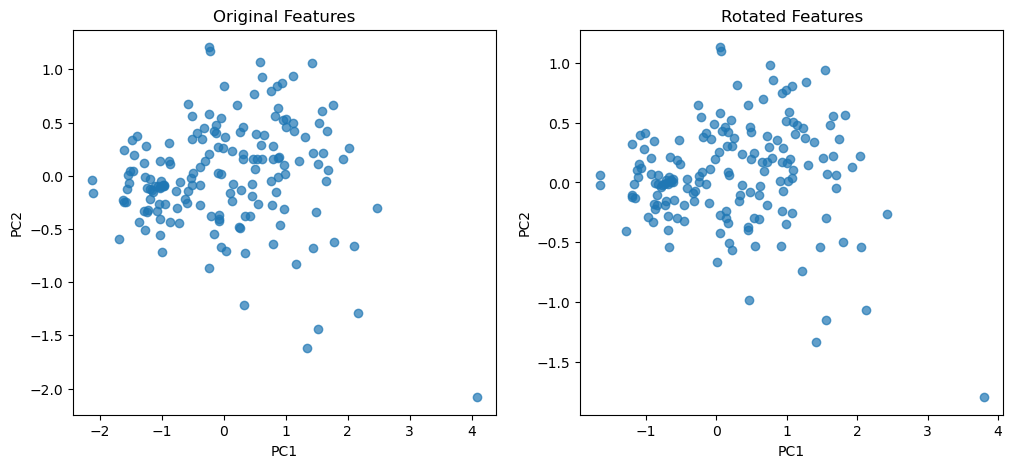

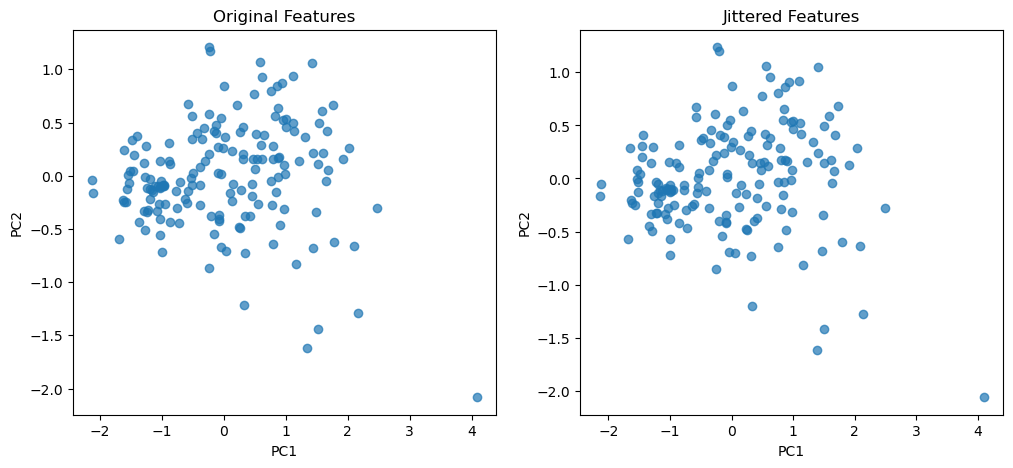

In [15]:
X_rotated = rotate_features(csp_features_per_subject[0], angle=5)
X_jittered = jitter_features(csp_features_per_subject[0], noise_level=0.02)

plot_pca(csp_features_per_subject[0], X_rotated, title_transformed="Rotated Features")
plot_pca(csp_features_per_subject[0], X_jittered, title_transformed="Jittered Features")

In [85]:
from sklearn.manifold import TSNE

def plot_tsne(X_original, X_transformed, title_original="Original Features", title_transformed="Transformed Features"):
    """
    Plots 2D t-SNE of CSP features before and after transformation.
    """
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    X_combined = np.vstack([X_original, X_transformed])
    X_tsne = tsne.fit_transform(X_combined)

    X_original_tsne = X_tsne[:X_original.shape[0]]
    X_transformed_tsne = X_tsne[X_original.shape[0]:]

    plt.figure(figsize=(12, 5))

    # Original features
    plt.subplot(1, 2, 1)
    plt.scatter(X_original_tsne[:, 0], X_original_tsne[:, 1], alpha=0.7)
    plt.title(title_original)
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")

    # Transformed features
    plt.subplot(1, 2, 2)
    plt.scatter(X_transformed_tsne[:, 0], X_transformed_tsne[:, 1], alpha=0.7)
    plt.title(title_transformed)
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")

    plt.show()

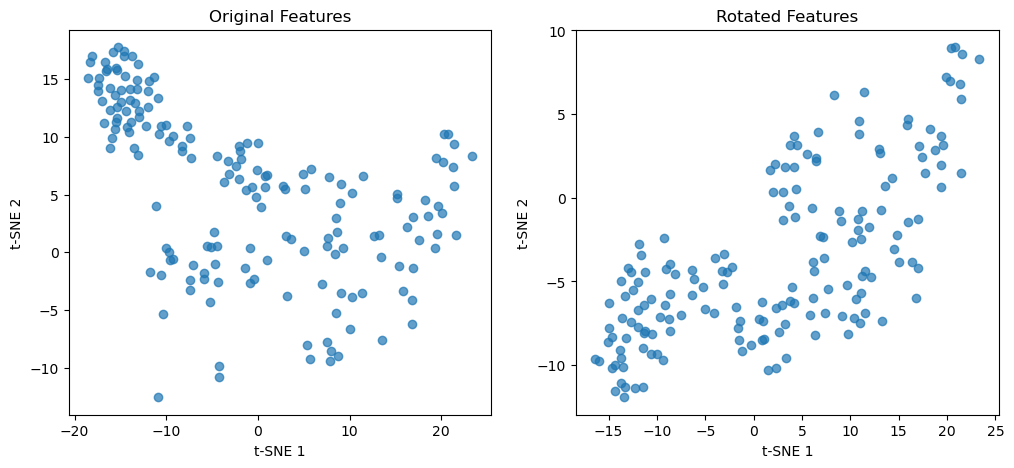

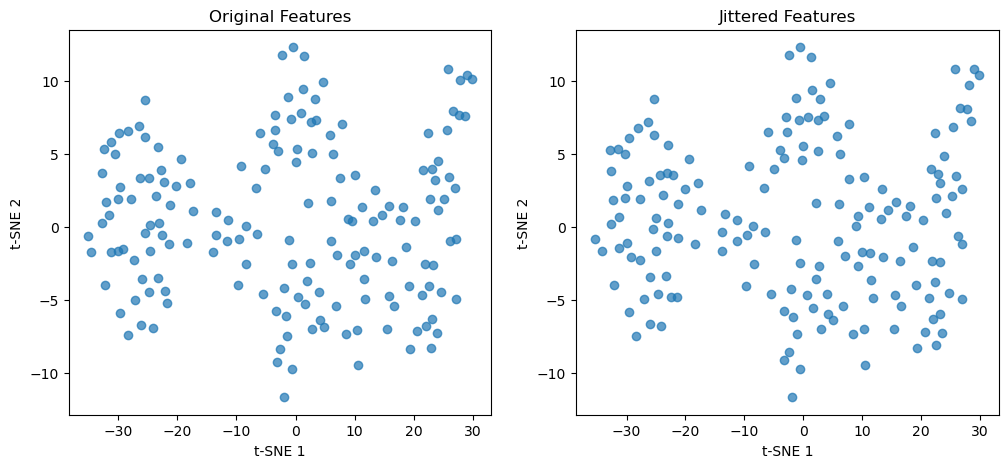

In [73]:
plot_tsne(csp_features_per_subject[0], X_rotated, title_transformed="Rotated Features")
plot_tsne(csp_features_per_subject[0], X_jittered, title_transformed="Jittered Features")

In [100]:
csp_features_per_subject[0].shape
csp_features_per_subject[1].shape

x_1 = X_rotated
x_2 = csp_features_per_subject[2]

y_1 = labels_per_subject[0]
y_2 = labels_per_subject[2]

lda = LinearDiscriminantAnalysis()

lda.fit(x_1, y_1)

y_pred = lda.predict(x_2)

print(accuracy_score(y_2, y_pred))

0.7976190476190477


# Reinforcment Learning 

In [38]:
import gym 
import numpy as np
from gym import spaces

class EEGFeatureEnv(gym.Env):
    def __init__(self, X_train, y_train, other_subjects_X, other_subjects_y, classifier):

        super(EEGFeatureEnv, self).__init__()

        self.X_train = X_train
        self.y_train = y_train
        self.classifier = classifier

        self.tot_X = other_subjects_X
        self.tot_y = other_subjects_y

        self.curr_ind = 0

        self.observation_space = gym.spaces.Box(low=-100000, high=100000, shape=(X_train.shape[1],), dtype=np.float32)

        self.action_space = gym.spaces.Discrete(6)

        #print('init')

    def step(self, action):

        #print(f"Agent took action: {action}")

        feature_vector = self.X_train[self.curr_ind].copy()

        feature_vector = self.apply_jitter(feature_vector, action)
        
        transformed_X = self.X_train.copy()

        transformed_X[self.curr_ind] = feature_vector

        accuracy = self.compute_tot_accuracy(transformed_X, self.y_train)

        reward = accuracy - self.initial_acc

        #print(reward)

        self.curr_ind += 1
        done = self.curr_ind >= len(self.X_train)

        return feature_vector, reward, done, {}
    
    def apply_rotation(self, feature_vector, rotation):
        pass

    def apply_jitter(self, feature_vector, action):
        
        levels = [0.0, 0.1, 0.05, 0.01, 0.005, 0.01]
        noise_level = levels[action]

        feature_vector = np.random.normal(0, noise_level, feature_vector.shape)
        return feature_vector

    def compute_tot_accuracy(self, transformed_X, y_train):

        self.classifier.fit(transformed_X, y_train)

        tot_acc = []

        for x, label in zip(self.tot_X, self.tot_y):


            y_pred = self.classifier.predict(x)

            accuracy = accuracy_score(y_pred, label)

            tot_acc.append(accuracy)

        return np.mean(tot_acc)

    
    def reset(self):

        self.curr_ind = 0
        self.initial_acc = self.compute_tot_accuracy(self.X_train, self.y_train)
        #print(self.initial_acc)

        return self.X_train[self.curr_ind]
    
    def render(self, mode='human'):
        pass


In [31]:
from sklearn.preprocessing import StandardScaler
X_train = csp_features_per_subject[0]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

clf = LinearDiscriminantAnalysis()
clf.fit(csp_features_per_subject[0], labels_per_subject[0])

LinearDiscriminantAnalysis()

In [39]:
features_minus_first = csp_features_per_subject[1:]
labels_minus_first = labels_per_subject[1:]

print(len(features_minus_first))
env = EEGFeatureEnv(X_train=csp_features_per_subject[0], y_train=labels_per_subject[0],other_subjects_X=features_minus_first, other_subjects_y=labels_minus_first, classifier=clf)



4


In [40]:
from stable_baselines3 import PPO


model = PPO('MlpPolicy', env, learning_rate=1e-4, verbose=1)
model.learn(total_timesteps=10000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Users\jacob\anaconda3\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 168      |
|    ep_rew_mean     | -0.532   |
| time/              |          |
|    fps             | 149      |
|    iterations      | 1        |
|    time_elapsed    | 13       |
|    total_timesteps | 2048     |
---------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 168           |
|    ep_rew_mean          | -0.532        |
| time/                   |               |
|    fps                  | 143           |
|    iterations           | 2             |
|    time_elapsed         | 28            |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 0.00020354701 |
|    clip_fraction        | 0.00137       |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.79         |
|    explained_variance   | -29.9         |


In [42]:
from sklearn.metrics import accuracy_score

episode_rewards = []
obs = env.reset()
for i in range(len(X_train)):
    action, _ = model.predict(obs)
    obs, reward, done, info = env.step(action)
    episode_rewards.append(reward)

    if done or obs.shape == ():
        print(f"Episode {i+1}, Total Reward: {sum(episode_rewards)}")
        episode_rewards = []  # Reset for next episode
        obs = env.reset()
    
    

Episode 168, Total Reward: -0.5386904761904745


# Maybe GAN?